## Movielens

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *
import pandas as pd

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [29]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [30]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [31]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [32]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [34]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [35]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.792483   0.809172  
    1      0.788783   0.778992                                  
    2      0.601386   0.766039                                  



[array([0.76604])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [36]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [37]:
preds = learn.predict()

/home/hamim/anaconda3/envs/fastai3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


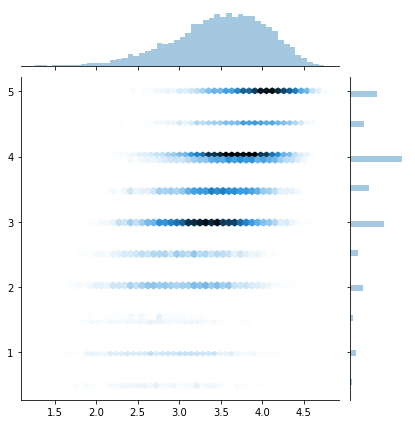

In [38]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [39]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [40]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [41]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [42]:
movie_bias

array([[ 0.78135],
       [ 0.82859],
       [ 1.30499],
       ...,
       [ 0.27452],
       [-0.01273],
       [ 0.15957]], dtype=float32)

In [43]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [44]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.91197544, 'Battlefield Earth (2000)'),
 (-0.7982166, 'Super Mario Bros. (1993)'),
 (-0.7434314, 'Wild Wild West (1999)'),
 (-0.69656837, 'Speed 2: Cruise Control (1997)'),
 (-0.67899185, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6723572, 'Inspector Gadget (1999)'),
 (-0.66633004, 'Anaconda (1997)'),
 (-0.648702, 'Batman & Robin (1997)'),
 (-0.6244586, 'Congo (1995)'),
 (-0.6196918, "Joe's Apartment (1996)"),
 (-0.61859274, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.6102416, 'Blade: Trinity (2004)'),
 (-0.60008454, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.59932107, 'Bio-Dome (1996)'),
 (-0.59645647, 'Showgirls (1995)')]

In [84]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.96070349, 'Battlefield Earth (2000)'),
 (-0.76858485, 'Speed 2: Cruise Control (1997)'),
 (-0.73675376, 'Wild Wild West (1999)'),
 (-0.73655486, 'Anaconda (1997)'),
 (-0.72457194, 'Super Mario Bros. (1993)'),
 (-0.69564718, 'Congo (1995)'),
 (-0.67043746, 'Superman III (1983)'),
 (-0.64385736, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.62750411, "Joe's Apartment (1996)"),
 (-0.60154277, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.59929478, 'Batman & Robin (1997)'),
 (-0.59667748, 'Jaws 3-D (1983)'),
 (-0.5921765, 'Dungeons & Dragons (2000)'),
 (-0.59074384, 'Inspector Gadget (1999)'),
 (-0.57559621, 'Haunting, The (1999)')]

In [45]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3049933, 'Shawshank Redemption, The (1994)'),
 (1.0902408, 'Usual Suspects, The (1995)'),
 (1.0828072, 'Godfather, The (1972)'),
 (0.987135, "Schindler's List (1993)"),
 (0.97522295, 'Godfather: Part II, The (1974)'),
 (0.90627456, 'Fargo (1996)'),
 (0.87670016, 'Matrix, The (1999)'),
 (0.8687948, '12 Angry Men (1957)'),
 (0.8589916, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.84410894, 'Casablanca (1942)'),
 (0.83719045, 'Princess Bride, The (1987)'),
 (0.829459, 'Memento (2000)'),
 (0.8285923, 'Pulp Fiction (1994)'),
 (0.8272907, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.8254705, 'Silence of the Lambs, The (1991)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [46]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [48]:
movie_pca.shape

(3, 3000)

In [49]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08399595, 'Chinatown (1974)'),
 (0.08265744, '2001: A Space Odyssey (1968)'),
 (0.07405544, 'Godfather, The (1972)'),
 (0.073996514, 'Pulp Fiction (1994)'),
 (0.06547132, 'Goodfellas (1990)'),
 (0.06515086, 'Taxi Driver (1976)'),
 (0.06199045, 'High Fidelity (2000)'),
 (0.05950064, 'Citizen Kane (1941)'),
 (0.059262726, 'Casablanca (1942)'),
 (0.058188546, 'Fargo (1996)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.058013935, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.057071723, 'Mission: Impossible II (2000)'),
 (-0.05363082, 'Man in the Iron Mask, The (1998)'),
 (-0.053112544, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.053041823, 'Three Musketeers, The (1993)'),
 (-0.05270505, 'Waterworld (1995)'),
 (-0.051894516, 'Lake Placid (1999)'),
 (-0.051387526, 'Back to the Future Part III (1990)'),
 (-0.05028918, 'Con Air (1997)'),
 (-0.05012434, 'Police Academy 5: Assignment: Miami Beach (1988)')]

In [52]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10056786, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.09806292, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.096587874, 'Forrest Gump (1994)'),
 (0.09650563, 'Lethal Weapon (1987)'),
 (0.09271633, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.09227028, 'Jurassic Park (1993)'),
 (0.09193627,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.08522503, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.08502346, 'Spider-Man (2002)'),
 (0.0831658, 'Shrek (2001)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.054739647, 'American Psycho (2000)'),
 (-0.050490007, 'Bringing Up Baby (1938)'),
 (-0.050111525, '8 1/2 (8½) (1963)'),
 (-0.049560647, 'Tank Girl (1995)'),
 (-0.04953128, 'Barbarella (1968)'),
 (-0.048834834, 'English Patient, The (1996)'),
 (-0.04775862, 'Hollow Man (2000)'),
 (-0.046692587, "Joe's Apartment (1996)"),
 (-0.046546962, 'Lost Highway (1997)'),
 (-0.04527437, 'Galaxy Quest (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

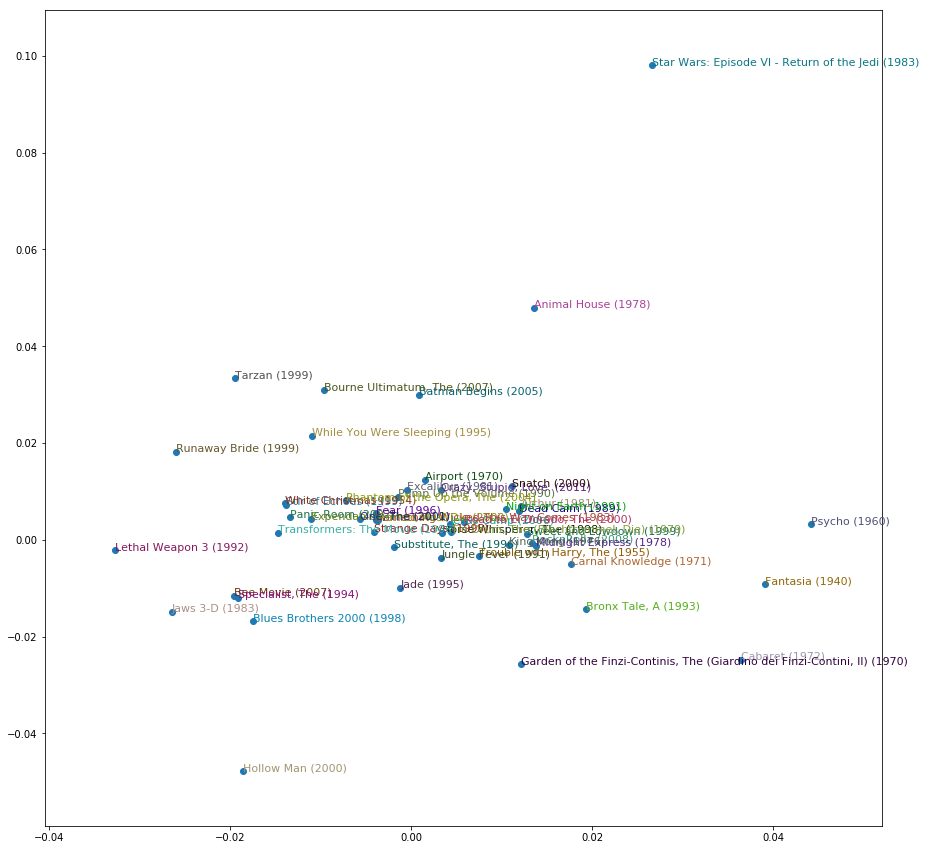

In [55]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Dot product model

In [56]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [57]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [58]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

### Bias

In [59]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [60]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e


### Mini net

In [22]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [62]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [63]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.891732   0.820156  
    1      0.84919    0.797119                                  
    2      0.804409   0.791197                                  



[array([0.7912])]

In [64]:
set_lrs(opt, 1e-3)

In [65]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.786781   0.785571  
    1      0.814335   0.791148                                  
    2      0.792906   0.79318                                   



[array([0.79318])]